In [1]:
onColab = True
model_path = './final_attention'

# Decide batch size and validation split
batch_size = 32
validation_split = 0.2
test_split = 0.01
epochs = 200

dataset_path = './Training_smooth4.csv'

window = 600
stride = 20
# 864 / 8
telescope = 108

## Init
Initialize codalab, libraries and seed

In [2]:
#@title connect to codalab
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2

Mounted at /gdrive
/gdrive/MyDrive/University/ANN/CHALLENGE2


In [3]:
#@title Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

tf.config.list_physical_devices('GPU')

2.7.0


[]

In [4]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Dataset import and manipulation

In [5]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.describe()

(68480, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000
mean,6.092920,4.695038,13.338328,2.448571,2.406236,23.226083,8.233430
std,1.850374,3.276466,11.400923,2.913896,0.977233,14.266769,11.008436
min,0.373821,-7.078339,-38.472928,-9.010756,-1.112682,-5.957617,-42.243983
25%,4.904697,2.311735,10.714054,0.459732,2.141207,12.586388,6.350049
50%,5.716294,4.707046,15.650564,2.624066,2.617749,20.122389,10.980270
75%,6.983160,7.004572,20.341672,4.606686,2.981460,31.173663,15.216130
max,15.390880,17.665553,38.461400,13.891042,4.938068,76.363976,28.687612


In [6]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
# inspect_dataframe(dataset, dataset.columns)

In [7]:
def normalize(dataset, t=None):
  if t is None or t == 'minmax':
    x_min = dataset.min(axis=0)
    print(x_min.shape)
    x_max = dataset.max()
    nd = (dataset - x_min) / (x_max - x_min)
    return nd
  elif t == 'mean_std':
    x_mean = dataset.mean()
    x_std = dataset.std()
    nd = (dataset - x_mean) / x_std
    return nd

In [8]:
normalized_ds = normalize(dataset)
normalized_ds.describe()

(7,)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000
mean,0.380840,0.475809,0.673448,0.500368,0.581567,0.354508,0.711635
std,0.123218,0.132415,0.148190,0.127234,0.161506,0.173305,0.155198
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.301715,0.379491,0.639337,0.413526,0.537766,0.225263,0.685083
50%,0.355760,0.476295,0.703503,0.508031,0.616524,0.316806,0.750360
75%,0.440122,0.569147,0.764478,0.594601,0.676634,0.451052,0.810078
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
def chunk(dataset, window, telescope, stride):
  """
  divide the dataset in chunks. 
  It keeps the right-most elements and discard the left ones, if size and stride are not compatible with dimensions. 
  """
  size = window + telescope
  X = []
  Y = []
  for i in range(len(dataset) - size, -1, -stride):
    X.append(dataset[i: i + window])
    Y.append(dataset[i + window: i + size])
  X.reverse()
  Y.reverse()
  return (np.array(X), np.array(Y))

In [10]:
x, y = chunk(normalized_ds, window, telescope, stride)

In [11]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

In [12]:
# shuffle data so that 
x, y = sklearn.utils.shuffle(x, y, random_state=seed)
x.shape, y.shape

((3389, 600, 7), (3389, 108, 7))

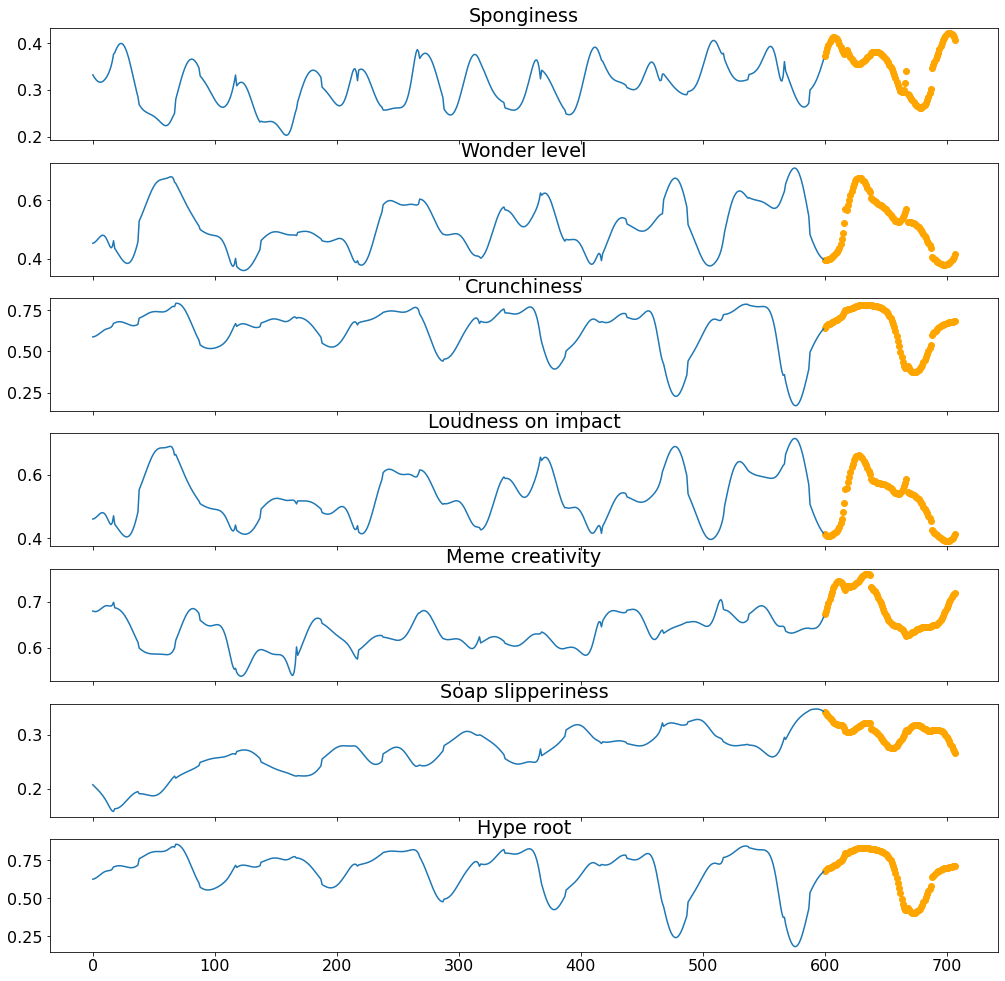

In [13]:
inspect_multivariate(x, y, dataset.columns, telescope)

## Model
build the model and learn

In [14]:
input_shape = (window, 7)
output_shape = (telescope, 7)

In [15]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # E1D1
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]

    #
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))    
    conv = tfkl.Conv1D(512, 3, padding='same', activation='relu')
    encoder_l1 = tf.keras.layers.LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_state=True)
    encoder_outputs1 = encoder_l1(conv(encoder_inputs))

    encoder_states1 = encoder_outputs1[1:]

    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

    #
    decoder_l1 = tf.keras.layers.LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

    #
    model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    model_e1d1.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model_e1d1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 7)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 600, 512)     11264       ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 256),        787456      ['conv1d[0][0]']                 
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

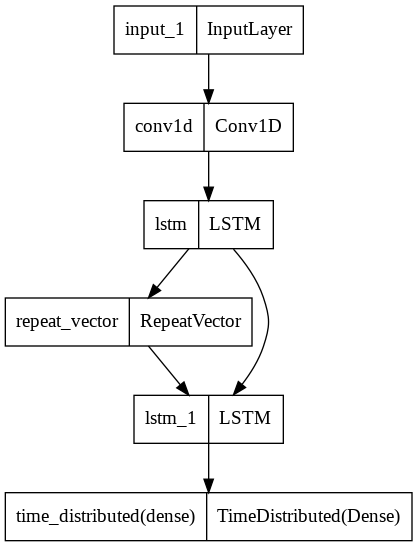

In [16]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [20]:
# Train the model
history = model.fit(
    x = x,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/200
85/85 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0385

85/85 [==============================] - 445s 5s/step - loss: 0.0031 - mae: 0.0385 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 6.2500e-05
Epoch 2/200
85/85 [==============================] - 417s 5s/step - loss: 0.0031 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 6.2500e-05
Epoch 3/200
85/85 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0383

85/85 [==============================] - 418s 5s/step - loss: 0.0031 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0419 - lr: 6.2500e-05
Epoch 4/200
85/85 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0383

85/85 [==============================] - 419s 5s/step - loss: 0.0031 - mae: 0.0383 - val_loss: 0.0039 - val_mae: 0.0418 - lr: 6.2500e-05
Epoch 5/200
85/85 [==============================] - 419s 5s/step - loss: 0.0031 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0418 - lr: 6.2500e-05
Epoch 6/200
85/85 [==============================] - 409s 5s/step - loss: 0.0030 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0419 - lr: 6.2500e-05
Epoch 7/200
85/85 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0379

85/85 [==============================] - 408s 5s/step - loss: 0.0030 - mae: 0.0379 - val_loss: 0.0039 - val_mae: 0.0417 - lr: 3.1250e-05
Epoch 8/200
85/85 [==============================] - 399s 5s/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0039 - val_mae: 0.0416 - lr: 3.1250e-05
Epoch 9/200
85/85 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0380

85/85 [==============================] - 426s 5s/step - loss: 0.0030 - mae: 0.0380 - val_loss: 0.0039 - val_mae: 0.0416 - lr: 3.1250e-05
Epoch 10/200
85/85 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0379

85/85 [==============================] - 423s 5s/step - loss: 0.0030 - mae: 0.0379 - val_loss: 0.0039 - val_mae: 0.0415 - lr: 3.1250e-05
Epoch 11/200
85/85 [==============================] - 417s 5s/step - loss: 0.0030 - mae: 0.0379 - val_loss: 0.0039 - val_mae: 0.0416 - lr: 3.1250e-05
Epoch 12/200
85/85 [==============================] - 416s 5s/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0415 - lr: 1.5625e-05
Epoch 13/200
85/85 [==============================] - 418s 5s/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0416 - lr: 1.5625e-05
Epoch 14/200
85/85 [==============================] - 424s 5s/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0416 - lr: 1.5625e-05
Epoch 15/200
85/85 [==============================] - 426s 5s/step - loss: 0.0029 - mae: 0.0376 - val_loss: 0.0039 - val_mae: 0.0416 - lr: 1.5625e-05
Epoch 16/200
85/85 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0376

85/85 [==============================] - 438s 5s/step - loss: 0.0029 - mae: 0.0376 - val_loss: 0.0039 - val_mae: 0.0415 - lr: 1.5625e-05
Epoch 17/200
85/85 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0376

85/85 [==============================] - 446s 5s/step - loss: 0.0030 - mae: 0.0376 - val_loss: 0.0039 - val_mae: 0.0416 - lr: 1.0000e-05
Epoch 18/200
85/85 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0375

85/85 [==============================] - 441s 5s/step - loss: 0.0029 - mae: 0.0375 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 19/200
85/85 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0376

85/85 [==============================] - 438s 5s/step - loss: 0.0029 - mae: 0.0376 - val_loss: 0.0039 - val_mae: 0.0415 - lr: 1.0000e-05
Epoch 20/200
85/85 [==============================] - 420s 5s/step - loss: 0.0029 - mae: 0.0375 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 21/200
85/85 [==============================] - 424s 5s/step - loss: 0.0029 - mae: 0.0376 - val_loss: 0.0039 - val_mae: 0.0415 - lr: 1.0000e-05
Epoch 22/200
85/85 [==============================] - 426s 5s/step - loss: 0.0029 - mae: 0.0374 - val_loss: 0.0039 - val_mae: 0.0415 - lr: 1.0000e-05
Epoch 23/200
85/85 [==============================] - 422s 5s/step - loss: 0.0029 - mae: 0.0374 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 24/200
85/85 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0375

85/85 [==============================] - 437s 5s/step - loss: 0.0029 - mae: 0.0375 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 25/200
85/85 [==============================] - 426s 5s/step - loss: 0.0029 - mae: 0.0374 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 26/200
85/85 [==============================] - 424s 5s/step - loss: 0.0029 - mae: 0.0374 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 27/200
85/85 [==============================] - 424s 5s/step - loss: 0.0029 - mae: 0.0375 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 28/200
85/85 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0374

85/85 [==============================] - 436s 5s/step - loss: 0.0029 - mae: 0.0374 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 29/200
85/85 [==============================] - 441s 5s/step - loss: 0.0029 - mae: 0.0375 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 30/200
85/85 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0374

85/85 [==============================] - 447s 5s/step - loss: 0.0029 - mae: 0.0374 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 31/200
85/85 [==============================] - 427s 5s/step - loss: 0.0029 - mae: 0.0373 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 32/200
85/85 [==============================] - 420s 5s/step - loss: 0.0029 - mae: 0.0374 - val_loss: 0.0039 - val_mae: 0.0414 - lr: 1.0000e-05
Epoch 33/200
41/85 [=============>................] - ETA: 3:32 - loss: 0.0029 - mae: 0.0373

KeyboardInterrupt: ignored

In [ ]:
model.save(model_path)

In [17]:
model = tfk.models.load_model("final_attention_ckpt")

In [ ]:
# model = tfk.models.load_model(model_path)

## Analytics
Here we compute some analytics (just to get a very rough idea: there is no test set, thus these analytics are not so good!)

In [18]:
predictions = model.predict(x)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(3389, 108, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0028936006>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.036473293>)

In [19]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

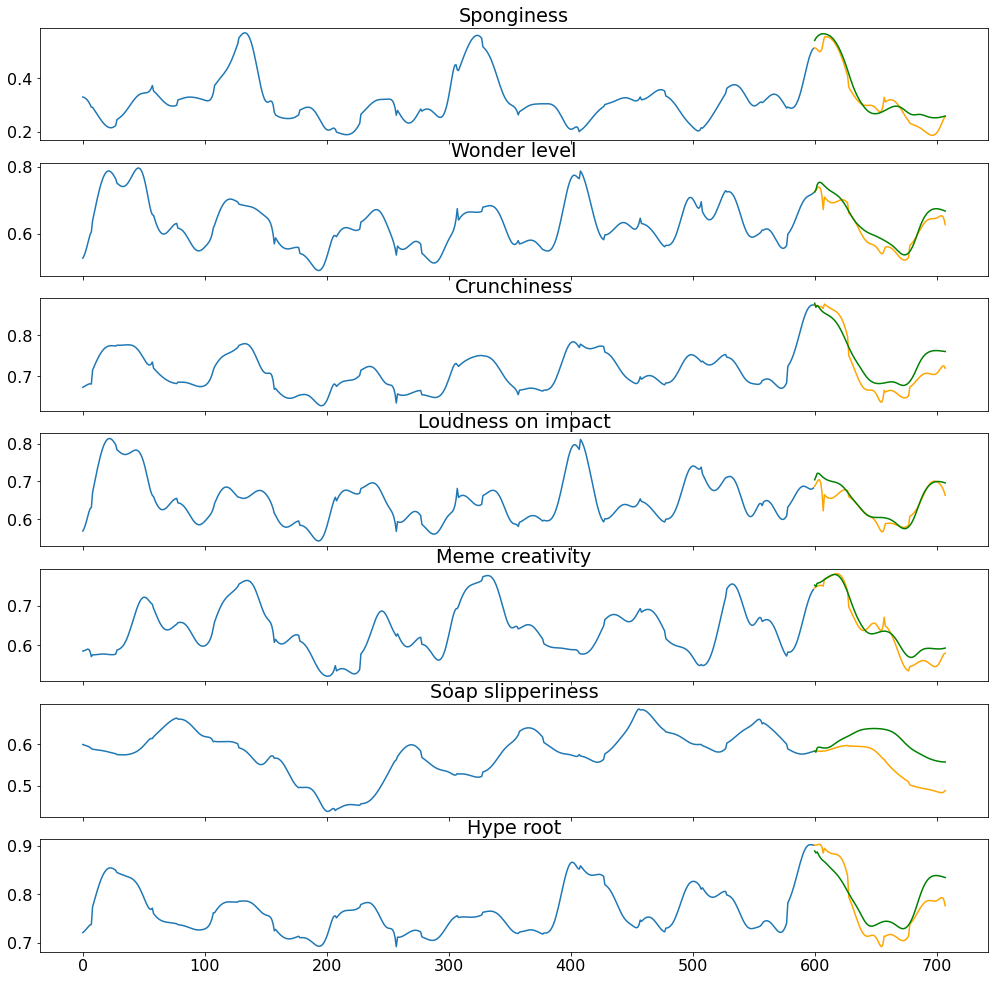

In [20]:
inspect_multivariate_prediction(x, y, predictions, dataset.columns, telescope)

In [21]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [22]:
reg_telescope = 864
X_test_reg, y_test_reg  = chunk(normalized_ds, window, reg_telescope, stride)
X_test_reg = X_test_reg[-10:]
y_test_reg = y_test_reg[-10:]
X_test_reg.shape, y_test_reg.shape

((10, 600, 7), (10, 864, 7))

In [23]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [24]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.004405406>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.04455518>)

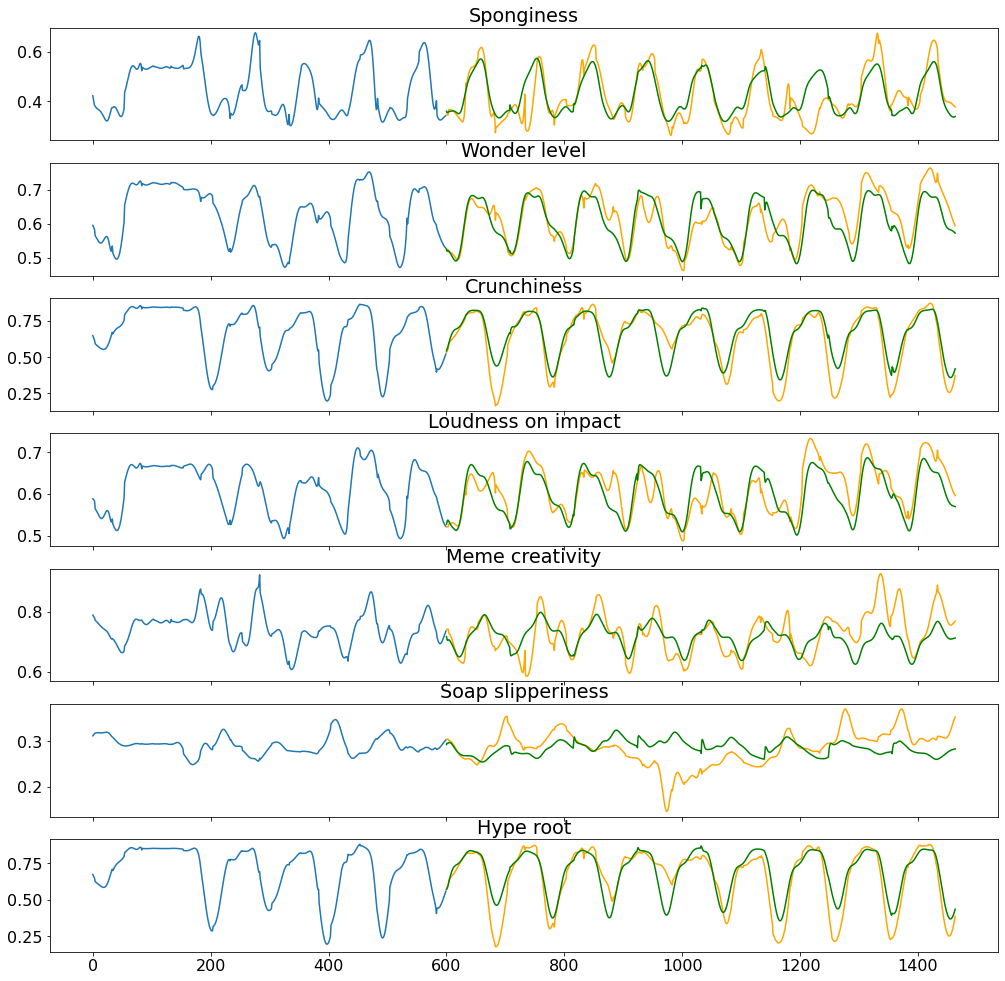

In [25]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, dataset.columns, reg_telescope, 8)